In [17]:
# --- CONFIGURATION ---
# Path to the main directory containing all experiment subfolders
# Example: "/root/ray_results/PPO_CooperativePong_Experiment_Name"
GRID_SEARCH_DIR = "/home/nricciardi/Repositories/marl-project/checkpoints/multiwalker/PPO_2025-12-11_21-49-44"

📂 Scanning directory: /home/nricciardi/Repositories/marl-project/checkpoints/multiwalker/PPO_2025-12-11_21-49-44 ...
🏆 Best Performing Trial selected for plotting: Trial_0


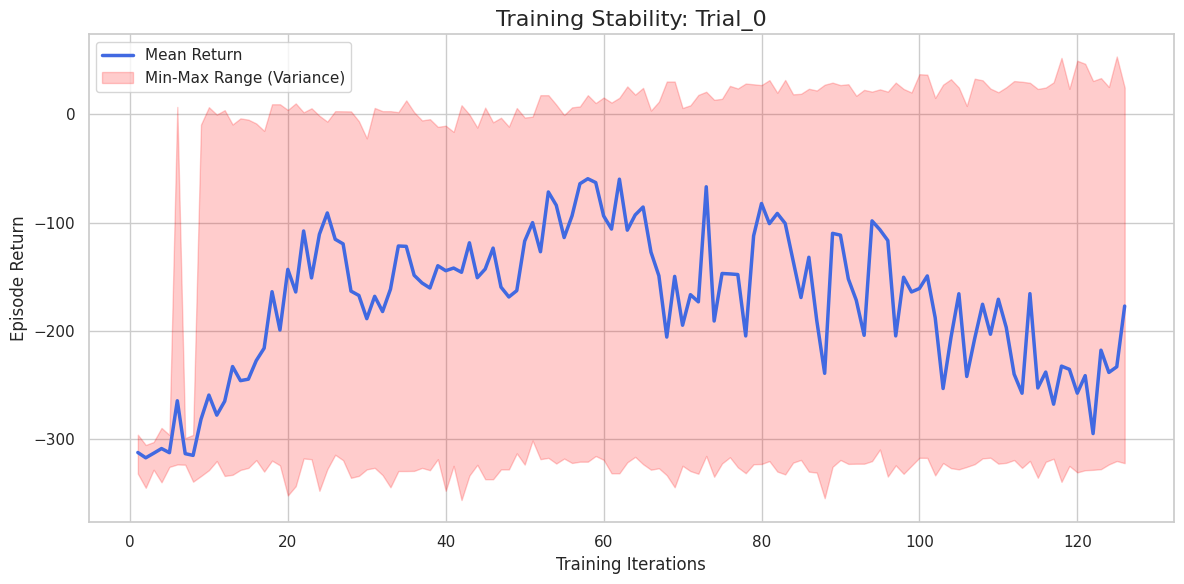

In [18]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def load_detailed_results(root_dir):
    """
    Scans for result.json and extracts Mean, Min, and Max returns.
    """
    all_data = []
    
    print(f"📂 Scanning directory: {root_dir} ...")
    subdirs = [f.path for f in os.scandir(root_dir) if f.is_dir()]
    
    for i, folder_path in enumerate(subdirs):
        json_file = os.path.join(folder_path, "result.json")
        
        if os.path.exists(json_file):
            trial_id = f"Trial_{i}"
            try:
                with open(json_file, 'r') as f:
                    for line in f:
                        try:
                            record = json.loads(line)
                            
                            # 1. Extract Metrics (prioritizing env_runners structure)
                            # RLlib often nests these inside 'env_runners'
                            runners = record.get("env_runners", {})
                            
                            # Fetch Mean, Max, Min
                            r_mean = runners.get("episode_return_mean")
                            r_max = runners.get("episode_return_max")
                            r_min = runners.get("episode_return_min")

                            # Fallback for older RLlib versions or simple structures
                            if r_mean is None: 
                                r_mean = record.get("episode_reward_mean")
                            if r_max is None: 
                                r_max = record.get("episode_reward_max")
                            if r_min is None: 
                                r_min = record.get("episode_reward_min")

                            # Only append if we have valid data
                            if r_mean is not None:
                                all_data.append({
                                    "trial_id": trial_id,
                                    "iteration": record.get("training_iteration"),
                                    "return_mean": r_mean,
                                    "return_max": r_max,
                                    "return_min": r_min,
                                    "path": folder_path
                                })
                                
                        except json.JSONDecodeError:
                            continue
            except Exception as e:
                print(f"⚠️ Error reading {folder_path}: {e}")

    if not all_data:
        return None
    return pd.DataFrame(all_data)

# --- EXECUTION ---

df = load_detailed_results(GRID_SEARCH_DIR)

if df is not None:
    # 1. Identify the Best Trial (to plot the most relevant one)
    # We select the trial that achieved the highest single mean return
    best_trial_id = df.loc[df['return_mean'].idxmax()]['trial_id']
    print(f"🏆 Best Performing Trial selected for plotting: {best_trial_id}")
    
    # Filter data for only the best trial
    best_df = df[df['trial_id'] == best_trial_id].sort_values("iteration")
    
    # 2. Setup Plot
    plt.figure(figsize=(12, 6))
    sns.set_theme(style="whitegrid")
    
    # A. Plot the Mean Line
    sns.lineplot(
        data=best_df,
        x="iteration",
        y="return_mean",
        color="royalblue",
        linewidth=2.5,
        label="Mean Return"
    )
    
    # B. Plot the Min/Max Band (Variance)
    # We use fill_between from matplotlib
    plt.fill_between(
        best_df["iteration"],
        best_df["return_min"],
        best_df["return_max"],
        color="red",
        alpha=0.2, # Transparency (0.0 to 1.0)
        label="Min-Max Range (Variance)"
    )
    
    # 3. Formatting
    plt.title(f"Training Stability: {best_trial_id}", fontsize=16)
    plt.xlabel("Training Iterations", fontsize=12)
    plt.ylabel("Episode Return", fontsize=12)
    plt.legend(loc="upper left")
    
    plt.tight_layout()
    plt.show()

else:
    print("❌ No data found.")